In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import nltk
import re

In [2]:
#Specify the file name
input_file = 'holmes.txt'

#Read the contents of the file
with open(input_file, 'r', encoding = 'utf-8') as infile:
    data = infile.read()

In [3]:
data[:200]

"*Project Gutenberg's Etext of Tom Swift And His Submarine Boat*\n\n#4 in the Victor Appleton's Tom Swift Series\n\nWe name these Etext files as they are numbered in the books,\n\ni.e. This is #4 in the seri"

In [4]:
data = data[:500000]

In [5]:
data

'*Project Gutenberg\'s Etext of Tom Swift And His Submarine Boat*\n\n#4 in the Victor Appleton\'s Tom Swift Series\n\nWe name these Etext files as they are numbered in the books,\n\ni.e. This is #4 in the series so the file name is 04tomxxx.xxx,\n\nwhere the x\'s are place holders for editon # and file type such\n\nas 04tom10.txt and 04tom10.zip, when we do a .htm, 04tom10h.htm\n\n\n\n\n\nCopyright laws are changing all over the world, be sure to check\n\nthe copyright laws for your country before posting these files!!\n\n\n\nPlease take a look at the important information in this header.\n\nWe encourage you to keep this file on your own disk, keeping an\n\nelectronic path open for the next readers.  Do not remove this.\n\n\n\n\n\n**Welcome To The World of Free Plain Vanilla Electronic Texts**\n\n\n\n**Etexts Readable By Both Humans and By Computers, Since 1971**\n\n\n\n*These Etexts Prepared By Hundreds of Volunteers and Donations*\n\n\n\nInformation on contacting Project Gutenberg to

In [6]:
# Function to remove emojis and special characters from text
def remove_emojis_and_special_characters(text):
   
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(' +', ' ', text)
    
    return text

In [7]:
# Preprocessing pipeline
def preprocess_pipeline(data) -> 'list':
    # Split by newline character
    sentences = data.split('\n')
    for i in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences]
    # Drop empty sentences
    sentences = [s for s in sentences if len(s) > 0]
    # Tokenization
    tokenized = []
    for sentence in sentences:
        # Convert to lowercase
        sentence = sentence.lower()
        tokenized.append(sentence)
    return tokenized

# Tokenize sentences
tokenized_sentences = preprocess_pipeline(data)

In [8]:
tokenized_sentences

['project gutenbergs etext of tom swift and his submarine boat',
 '4 in the victor appletons tom swift series',
 'we name these etext files as they are numbered in the books',
 'ie this is 4 in the series so the file name is 04tomxxxxxx',
 'where the xs are place holders for editon and file type such',
 'as 04tom10txt and 04tom10zip when we do a htm 04tom10hhtm',
 'copyright laws are changing all over the world be sure to check',
 'the copyright laws for your country before posting these files',
 'please take a look at the important information in this header',
 'we encourage you to keep this file on your own disk keeping an',
 'electronic path open for the next readers do not remove this',
 'welcome to the world of free plain vanilla electronic texts',
 'etexts readable by both humans and by computers since 1971',
 'these etexts prepared by hundreds of volunteers and donations',
 'information on contacting project gutenberg to get etexts and',
 'further information is included below w

In [9]:
"""
What is an OOV Token?
An out-of-vocabulary (OOV) token is a special token used in natural language processing (NLP) tasks to represent words that
are not present in the vocabulary of the model or tokenizer. When a word that is not in the vocabulary is encountered during
tokenization or text processing, it is replaced with the OOV token.

Why Use an OOV Token?
Using an OOV token helps handle unseen or unknown words during the training or inference phase of an NLP model. 
Instead of encountering errors or issues when encountering unknown words, the model can gracefully handle them by
representing them with the OOV token. This is particularly useful when working with real-world data where the vocabulary
of the model may not cover all possible words.
"""
# Tokenize words
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(tokenizer.word_index) + 1
# tokenizer.word_counts
# tokenizer.word_index
"""
n_gram example:
[3, 15, 8, 7, 20, 12, 6]

For the above sentece sentence, the code would generate the following n-gram sequences:

[3, 15]
[3, 15, 8]
[3, 15, 8, 7]
[3, 15, 8, 7, 20]
[3, 15, 8, 7, 20, 12]
[3, 15, 8, 7, 20, 12, 6]
"""

# Generate input sequences
input_sequences = []
for line in tokenized_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

In [10]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding = 'pre'))

In [11]:
 X, label = input_sequences[:,:-1],input_sequences[:,-1]

In [12]:
ys = tf.keras.utils.to_categorical(label, num_classes = total_words)

In [13]:
#Split the data into training, validation and test sets
from sklearn.model_selection import train_test_split
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, ys, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [14]:
# Define your model
model = Sequential()
model.add(Embedding(total_words, 100)) 
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
history = model.fit(X_train_temp, y_train_temp, epochs=50, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 77s 36ms/step - accuracy: 0.0982 - loss: 6.2992 - val_accuracy: 0.1411 - val_loss: 5.6463
Epoch 2/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.1546 - loss: 5.1768 - val_accuracy: 0.1484 - val_loss: 5.6159
Epoch 3/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.1769 - loss: 4.6584 - val_accuracy: 0.1516 - val_loss: 5.7495
Epoch 4/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 73s 37ms/step - accuracy: 0.1972 - loss: 4.3738 - val_accuracy: 0.1435 - val_loss: 6.3517
Epoch 5/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.2013 - loss: 4.4365 - val_accuracy: 0.1495 - val_loss: 6.2612
Epoch 6/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 67s 33ms/step - accuracy: 0.2267 - loss: 3.9669 - val_accuracy: 0.1429 - val_loss: 6.4857
Epoch 7/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 77s 38ms/step - accuracy: 0.2344 - loss: 3.8139 - val_accuracy: 0.1478 - val_loss: 6.6895
Epoch 8/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 75s 37ms/step - accuracy: 0.2505 -

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

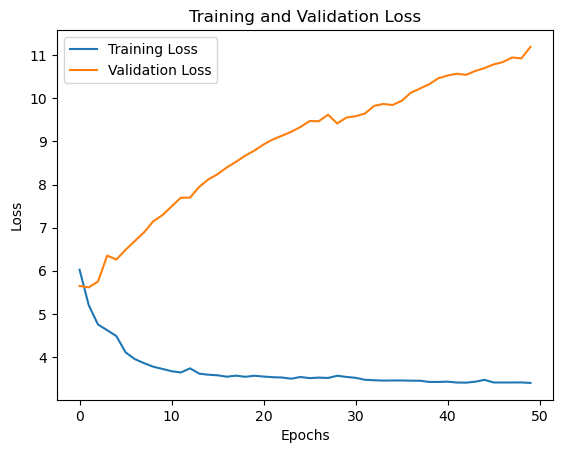

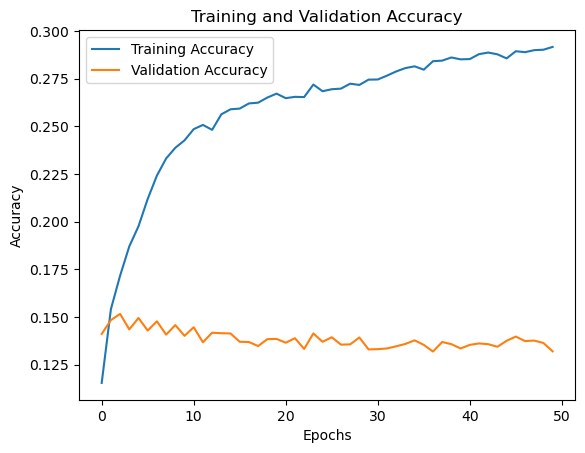

In [16]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
from IPython.display import HTML

def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words

def predict_and_display_top_five_words(seed_text, model, tokenizer):
    top_five_words = predict_top_five_words(model, tokenizer, seed_text)
    heading_app = f"<h1>Sentence AutoCompletion App With Five Outputs</h1>"
    output_text = f"<ul>{''.join([f'<li>{seed_text} {word}</li>' for word in top_five_words])}</ul>"
    javascript_code = f"""
    <script>
        var newWindow = window.open("", "_blank");
        newWindow.document.write('<html><head><title>Top Five Words</title></head><body>{heading_app} <br> <hr> {output_text}</body></html>');
    </script>
    """
    return HTML(javascript_code)

In [23]:
# Test the function
seed_text = "She is my"
predict_and_display_top_five_words(seed_text, model, tokenizer)

In [24]:
# Test 2:
# Test the function
seed_text = "I have"
predict_and_display_top_five_words(seed_text, model, tokenizer)

In [25]:
# Test 3:
seed_text = "How are"
predict_and_display_top_five_words(seed_text, model, tokenizer)